In [1]:
import numpy as np
import pandas as pd

from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras import callbacks
from keras.layers import Dense,Dropout,BatchNormalization,Convolution1D, MaxPooling1D, Flatten,LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score,roc_curve,auc,f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score,recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC

from art.attacks import FastGradientMethod, SaliencyMapMethod, BasicIterativeMethod
from art.attacks import CarliniL2Method, CarliniLInfMethod, ZooAttack, DeepFool, BoundaryAttack
from art.attacks import ElasticNet, NewtonFool, ProjectedGradientDescent, VirtualAdversarialMethod
from art.classifiers import KerasClassifier

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#plt.style.use('bmh')

%matplotlib inline

Using TensorFlow backend.


In [2]:
names=['duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
       'wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised',
       'root_shell','su_attempted','num_root','num_file_creations','num_shells',
       'num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
       'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate'
       ,'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
       'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
       'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
       'connection_type','label']

In [3]:
traindata = pd.read_csv('data/Training.csv',names=names,header=None)
testdata = pd.read_csv('data/Testing.csv',names=names, header=None)
print("Shape of Train and Test DF : ",traindata.shape," : ",testdata.shape)

Shape of Train and Test DF :  (125973, 43)  :  (22544, 43)


In [4]:
x_train = np.array(traindata.iloc[:,0:41])
x_test = np.array(testdata.iloc[:,0:41])

y_train =  np.array(traindata.iloc[:,42])
y_test = np.array(testdata.iloc[:,42])

print("Shape of Train and Test : ",x_train.shape," : ",x_test.shape)

Shape of Train and Test :  (125973, 41)  :  (22544, 41)


In [5]:
scaler = Normalizer().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [6]:
y_train_oh= to_categorical(y_train)
y_test_oh= to_categorical(y_test)

In [7]:
x_train_lstm = np.reshape(x_train, (x_train.shape[0],1,x_train.shape[1]))
x_test_lstm = np.reshape(x_test, (x_test.shape[0],1,x_test.shape[1]))
print("Shape of Train and Test : ",x_train.shape," : ",x_test.shape)

Shape of Train and Test :  (125973, 41)  :  (22544, 41)


In [8]:
x_train_cnn = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test_cnn = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
print("Shape of Train and Test : ",x_train.shape," : ",x_test.shape)

Shape of Train and Test :  (125973, 41)  :  (22544, 41)


In [9]:
def printMetrics(true,pred):
    print("Accuracy : ",accuracy_score(true, pred))
    print("Precision",precision_score(true, pred , average="weighted"))
    print("Recall : ",recall_score(true, pred , average="weighted"))
    print("F1-score : ",f1_score(true, pred, average="weighted"))
    print("Confusion Matrix : ")
    print(confusion_matrix(true, pred))

In [10]:
def adversarialFeatures(actual,adversarial,data):
    feats=dict()
    total=0
    orig_attack=actual - adversarial
    for i in range(0,orig_attack.shape [0]) :
        ind=np.where(orig_attack [i,:] != 0) [0]
        total += len(ind)
        for j in ind :
            if j in feats :
                feats [j] += 1
            else :
                feats [j]=1
                
    # The number of features that where changed for the adversarial samples
    print(" Number of unique features changed :",len(feats.keys()))
    print(" Number of average features changed per datapoint ",total / len(orig_attack))

    top_10=sorted(feats,key=feats.get,reverse=True) [:10]
    top_20=sorted(feats,key=feats.get,reverse=True) [:20]


    print(" Top ten features :",data.columns [ top_10 ])

    top_10_val=[100* feats [k ] / y_test.shape [0] for k in top_10 ]
    top_20_val=[100* feats [k ] / y_test.shape [0] for k in top_20 ]


    plt.bar(np.arange(20),top_20_val,align ='center')
    plt.xticks(np.arange(20),data.columns [ top_20 ],rotation ='vertical')
    plt.title('Feature participation in adversarial examples')
    plt.ylabel('Percentage(%)')
    plt.xlabel('Features')

In [11]:
dnnmodel = Sequential()
dnnmodel.add(Dense(1024,input_dim=41,activation='relu'))
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(768,activation='relu'))
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(512,activation='relu')) 
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(256,activation='relu'))
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(128,activation='relu')) 
dnnmodel.add(BatchNormalization())
dnnmodel.add(Dropout(0.01))
dnnmodel.add(Dense(5,activation='softmax'))
dnnmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
dnnmodel.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              43008     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               787200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 768)               3072      
_________________________________________________________________
dropout_2 (Dropout)  

In [12]:
cnnmodel = Sequential()
cnnmodel.add(Convolution1D(64, 3, border_mode="same",activation="relu",input_shape=(41, 1)))
cnnmodel.add(Convolution1D(64, 3, border_mode="same", activation="relu"))
cnnmodel.add(MaxPooling1D(pool_length=(2)))
cnnmodel.add(Convolution1D(128, 3, border_mode="same", activation="relu"))
cnnmodel.add(Convolution1D(128, 3, border_mode="same", activation="relu"))
cnnmodel.add(MaxPooling1D(pool_length=(2)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(128, activation="relu"))
cnnmodel.add(Dropout(0.5))
cnnmodel.add(Dense(5, activation="softmax"))
cnnmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnnmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 41, 64)            256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 20, 128)           24704     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
__________

c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, activation="relu", input_shape=(41, 1), padding="same")`
  
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  after removing the cwd from sys.path.
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(128, 3, activation="relu", padding="same")`
  """
c:\users\sriram\appdata\local\pr

In [13]:
lstmmodel = Sequential()
lstmmodel.add(LSTM(64,input_dim=41, return_sequences=True))  # try using a GRU instead, for fun
lstmmodel.add(Dropout(0.1))
lstmmodel.add(LSTM(64,return_sequences=True))  # try using a GRU instead, for fun
lstmmodel.add(Dropout(0.1))
lstmmodel.add(LSTM(64, return_sequences=True))  # try using a GRU instead, for fun
lstmmodel.add(Dropout(0.1))
lstmmodel.add(LSTM(64, return_sequences=False))  # try using a GRU instead, for fun
lstmmodel.add(Dropout(0.1))
lstmmodel.add(Dense(5,activation='softmax'))
lstmmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstmmodel.summary()

c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, input_shape=(None, 41))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 64)          27136     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
__________

In [14]:
dnnmodel.load_weights('Colab_run/results/DNN/checkpoint-80.hdf5')
cnnmodel.load_weights('Colab_run/results/CNN/checkpoint-54.hdf5')
lstmmodel.load_weights('Colab_run/results/LSTM/checkpoint-10.hdf5')

In [15]:
dnnPred = dnnmodel.predict_classes(x_test,verbose=1)
printMetrics(y_test,dnnPred)

22544/22544 [==============================] - 3s 151us/step
Accuracy :  0.7739088005677786
Precision 0.7836809718638511
Recall :  0.7739088005677786
F1-score :  0.758048679867562
Confusion Matrix : 
[[9366   47  278    1   19]
 [1207 5810  154    0  467]
 [ 671  188 1557    0    5]
 [  56    0    1    8    2]
 [1879    3  116    3  706]]


In [16]:
cnnPred = cnnmodel.predict_classes(x_test_cnn,verbose=1)
printMetrics(y_test,cnnPred)

22544/22544 [==============================] - 3s 154us/step
Accuracy :  0.7537704045422285
Precision 0.806164934267871
Recall :  0.7537704045422285
F1-score :  0.7188649275948918
Confusion Matrix : 
[[9374   53  280    1    3]
 [1808 5739   91    0    0]
 [ 536  197 1675    0   13]
 [  61    0    0    6    0]
 [2392    3  112    1  199]]


In [17]:
lstmPred = lstmmodel.predict_classes(x_test_lstm,verbose=1)
printMetrics(y_test,lstmPred)

22544/22544 [==============================] - 1s 62us/step
Accuracy :  0.7465844570617459
Precision 0.7173759497528693
Recall :  0.7465844570617459
F1-score :  0.7001530648588894
Confusion Matrix : 
[[9440   59  207    0    5]
 [1577 5854  206    0    1]
 [ 678  210 1533    0    0]
 [  61    0    0    0    6]
 [2596    6  101    0    4]]


c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
classifier = KerasClassifier(clip_values=(np.min(x_train), np.max(x_train)), model=dnnmodel)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [31]:
fgsm = FastGradientMethod(classifier, 
                          eps=.01,
                          minimal=True,
                          eps_step=0.01,
                          num_random_init=35,
                          targeted=False,
                          batch_size=32)

x_test_adv_fgsm = fgsm.generate(x=x_test)

In [20]:
jsma=SaliencyMapMethod(classifier,batch_size=32)
x_test_adv_jsma=jsma.generate(x=x_test)

 Number of unique features changed : 41
 Number of average features changed per datapoint  29.044801277501776
 Top ten features : Index(['protocol_type', 'service', 'flag', 'count', 'srv_count',
       'dst_host_count', 'dst_host_srv_count', 'same_srv_rate',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate'],
      dtype='object')


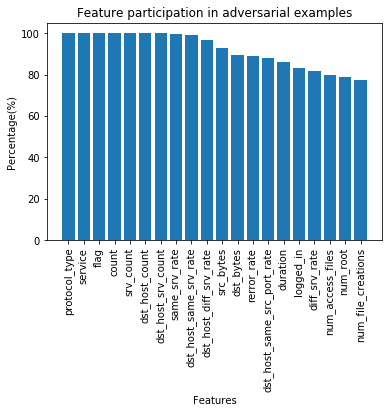

In [32]:
adversarialFeatures(x_test,x_test_adv_fgsm,testdata)

 Number of unique features changed : 41
 Number of average features changed per datapoint  37.046176366217175
 Top ten features : Index(['protocol_type', 'service', 'flag', 'count', 'srv_count',
       'dst_host_count', 'dst_host_srv_count', 'same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate'],
      dtype='object')


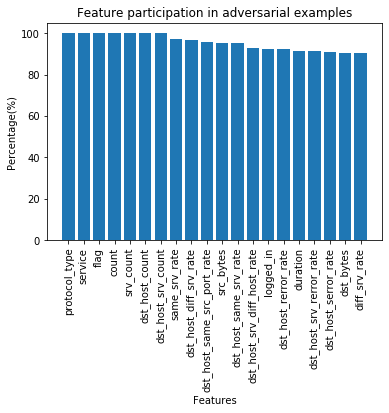

In [22]:
adversarialFeatures(x_test,x_test_adv_jsma,testdata)

In [33]:
dnnpredfgsm = dnnmodel.predict_classes(x_test_adv_fgsm,verbose=1)
dnnpredjsma = dnnmodel.predict_classes(x_test_adv_jsma,verbose=1)
printMetrics(y_test,dnnpredfgsm)
printMetrics(y_test,dnnpredjsma)

22544/22544 [==============================] - 3s 150us/step
Accuracy :  0.16749467707594037
Precision 0.30620367710276203
Recall :  0.16749467707594037
F1-score :  0.16021691321922113
Confusion Matrix : 
[[2046   21 1259  379 6006]
 [1532  123 1134    0 4849]
 [ 591   39  368   18 1405]
 [  15    0    2    0   50]
 [1254  167   42    5 1239]]
Accuracy :  0.10876508161816892
Precision 0.03939336977471973
Recall :  0.10876508161816892
F1-score :  0.03053454724529507
Confusion Matrix : 
[[  35    0  402    0 9274]
 [ 718    0    8    0 6912]
 [  61    0   55    0 2305]
 [   0    0    0    0   67]
 [   1    0  340    4 2362]]


In [34]:
x_test_adv_cnn_fgsm = np.reshape(x_test_adv_fgsm, (x_test_adv_fgsm.shape[0],x_test_adv_fgsm.shape[1],1))
x_test_adv_cnn_jsma = np.reshape(x_test_adv_jsma, (x_test_adv_jsma.shape[0],x_test_adv_jsma.shape[1],1))
cnnpredfgsm = cnnmodel.predict_classes(x_test_adv_cnn_fgsm,verbose=1)
cnnpredjsma = cnnmodel.predict_classes(x_test_adv_cnn_jsma,verbose=1)
printMetrics(y_test,cnnpredfgsm)
printMetrics(y_test,cnnpredjsma)

22544/22544 [==============================] - 3s 148us/step
Accuracy :  0.37837118523775726
Precision 0.358239733561271
Recall :  0.37837118523775726
F1-score :  0.35827347783217356
Confusion Matrix : 
[[6899 1435 1375    0    2]
 [1670  969 4999    0    0]
 [ 751 1008  662    0    0]
 [  40   16   11    0    0]
 [1487  978  242    0    0]]
Accuracy :  0.10069198012775017
Precision 0.242477619215898
Recall :  0.10069198012775017
F1-score :  0.07449500541027763
Confusion Matrix : 
[[ 263  161 9287    0    0]
 [ 355  515 6768    0    0]
 [ 556  370 1492    0    3]
 [   7    1   58    0    1]
 [ 390   28 2289    0    0]]


In [35]:
x_test_adv_lstm_fgsm = np.reshape(x_test_adv_fgsm, (x_test_adv_fgsm.shape[0],1,x_test_adv_fgsm.shape[1]))
x_test_adv_lstm_jsma = np.reshape(x_test_adv_jsma, (x_test_adv_jsma.shape[0],1,x_test_adv_jsma.shape[1]))
lstmpredfgsm = lstmmodel.predict_classes(x_test_adv_lstm_fgsm,verbose=1)
lstmpredjsma = lstmmodel.predict_classes(x_test_adv_lstm_jsma,verbose=1)
printMetrics(y_test,lstmpredfgsm)
printMetrics(y_test,lstmpredjsma)

22544/22544 [==============================] - 1s 42us/step
Accuracy :  0.2451650106458481
Precision 0.32473966381140074
Recall :  0.2451650106458481
F1-score :  0.25367172406477045
Confusion Matrix : 
[[4229  419 4582    0  481]
 [2376  549 4713    0    0]
 [1014  937  470    0    0]
 [  21    6   30    0   10]
 [2010  217  201    0  279]]
Accuracy :  0.46495741660752304
Precision 0.45442810399870764
Recall :  0.46495741660752304
F1-score :  0.3372930846647964
Confusion Matrix : 
[[9255   59  397    0    0]
 [7256  241  141    0    0]
 [1295  141  985    0    0]
 [  60    2    3    0    2]
 [2518   88  100    0    1]]


In [37]:
def advMLEval(ML):
    print("\nFGSM\n")
    printMetrics(y_test, ML.predict(x_test_adv_fgsm))
    print("\nJSMA\n")
    printMetrics(y_test, ML.predict(x_test_adv_jsma))

In [38]:
#Machine learning
LR = LogisticRegression()
LR.fit(x_train,y_train)
LR_Predprob=LR.predict_proba(x_test)
LR_Pred=LR_Predprob.argmax(axis=1)
printMetrics(y_test, LR_Pred)
advMLEval(LR)

c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy :  0.6332948899929027
Precision 0.5588961084949342
Recall :  0.6332948899929027
F1-score :  0.5707330798242316
Confusion Matrix : 
[[8985  650   76    0    0]
 [2542 4887  209    0    0]
 [ 890 1126  405    0    0]
 [  67    0    0    0    0]
 [2573   20  114    0    0]]

FGSM

Accuracy :  0.6227821149751597
Precision 0.5481161704524244
Recall :  0.6227821149751597
F1-score :  0.5543466083339869
Confusion Matrix : 
[[8999  655   57    0    0]
 [2689 4778  171    0    0]
 [ 923 1235  263    0    0]
 [  67    0    0    0    0]
 [2568  120   19    0    0]]

JSMA

Accuracy :  0.14389638041163946
Precision 0.2584972736324518
Recall :  0.14389638041163946
F1-score :  0.10007934873378088
Confusion Matrix : 
[[ 484  165   67    0 8995]
 [ 660  216    4    0 6758]
 [ 408  964  301    0  748]
 [   9    0    0    0   58]
 [ 370   86    8    0 2243]]


c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no pr

In [39]:
GNB = GaussianNB()
GNB.fit(x_train,y_train)
GNB_Predprob=GNB.predict_proba(x_test)
GNB_Pred=GNB_Predprob.argmax(axis=1)
printMetrics(y_test, GNB_Pred)
# np.savetxt(LOG_PATH+'GaussianNB/predict_proba.txt', GNB_Predprob, fmt='%06f')
# np.savetxt(LOG_PATH+'GaussianNB/confusion_matrix.txt', confusion_matrix(y_test,GNB_Pred), fmt='%01d')
advMLEval(GNB)

Accuracy :  0.44419801277501775
Precision 0.6322850713099508
Recall :  0.44419801277501775
F1-score :  0.48299717828721667
Confusion Matrix : 
[[2225 1099   81 4677 1629]
 [ 154 5832   16 1020  616]
 [ 162 1334  919    1    5]
 [   3    6    0   56    2]
 [ 788  411  209  317  982]]

FGSM

Accuracy :  0.33760645848119236
Precision 0.22648720611666334
Recall :  0.33760645848119236
F1-score :  0.25314940439690364
Confusion Matrix : 
[[6375   17    0  111 3208]
 [5468    2    2 1118 1048]
 [2123    9    0    2  287]
 [  52    0    0    3   12]
 [1447    1   20    8 1231]]

JSMA

Accuracy :  0.436124911284599
Precision 0.293931573605608
Recall :  0.436124911284599
F1-score :  0.30586671117050707
Confusion Matrix : 
[[9289   52  103   54  213]
 [7038   10   65  331  194]
 [1321  105  355   80  560]
 [  59    0    3    1    4]
 [2343   69   94   24  177]]


In [40]:
KNN = KNeighborsClassifier()
KNN.fit(x_train,y_train)
KNN_Predprob=KNN.predict_proba(x_test)
KNN_Pred=KNN_Predprob.argmax(axis=1)
printMetrics(y_test, KNN_Pred)
# np.savetxt(LOG_PATH+'KNeighborsClassifier/predict_proba.txt', KNN_Predprob, fmt='%06f')
# np.savetxt(LOG_PATH+'KNeighborsClassifier/confusion_matrix.txt', confusion_matrix(y_test,KNN_Pred), fmt='%01d')
advMLEval(KNN)

Accuracy :  0.7350514549325763
Precision 0.741332354238502
Recall :  0.7350514549325763
F1-score :  0.7002238901487958
Confusion Matrix : 
[[9431  140  133    1    6]
 [1399 5534  545    2  158]
 [ 719  342 1360    0    0]
 [  53    0    1   10    3]
 [2341   87   43    0  236]]

FGSM

Accuracy :  0.6635911994322214
Precision 0.617973281099374
Recall :  0.6635911994322214
F1-score :  0.6147065100032018
Confusion Matrix : 
[[9316  207   64    2  122]
 [2055 4586  993    0    4]
 [ 708  674 1039    0    0]
 [  57    0    1    5    4]
 [2553  113   27    0   14]]

JSMA

Accuracy :  0.4927253371185238
Precision 0.47951950998531345
Recall :  0.4927253371185238
F1-score :  0.3850068035350497
Confusion Matrix : 
[[9397  130  184    0    0]
 [6926  704    8    0    0]
 [1001  415 1005    0    0]
 [  64    0    0    2    1]
 [2648   30   29    0    0]]


DT = DecisionTreeClassifier()
DT.fit(x_train,y_train)
DT_Predprob=DT.predict_proba(x_test)
DT_Pred=DT_Predprob.argmax(axis=1)
printMetrics(y_test, DT_Pred)
advMLEval(DT)

In [42]:
AB = AdaBoostClassifier(n_estimators=100)
AB.fit(x_train,y_train)
AB_Predprob=AB.predict_proba(x_test)
AB_Pred=AB_Predprob.argmax(axis=1)
printMetrics(y_test, AB_Pred)
advMLEval(AB)

Accuracy :  0.4312455642299503
Precision 0.5108228091291401
Recall :  0.4312455642299503
F1-score :  0.45849390590553374
Confusion Matrix : 
[[2963  173  296   22 6257]
 [2082 5007  543    1    5]
 [ 191 1314  906    1    9]
 [  14    0    1    2   50]
 [1387   77  364   35  844]]

FGSM

Accuracy :  0.17281760113555714
Precision 0.19719679581885358
Recall :  0.17281760113555716
F1-score :  0.1474958788312185
Confusion Matrix : 
[[2943  121  272  235 6140]
 [7453  109   27    1   48]
 [1955  151  262    3   50]
 [  10    0    0   17   40]
 [1299  138  654   51  565]]

JSMA

Accuracy :  0.038857345635202274
Precision 0.20122239680581783
Recall :  0.038857345635202274
F1-score :  0.06055938373874339
Confusion Matrix : 
[[ 318  101   84 9000  208]
 [ 782   89    9 6758    0]
 [ 817  513  341  748    2]
 [   1    0    0   58    8]
 [ 272    8  112 2245   70]]


In [43]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(x_train,y_train)
RF_Predprob=RF.predict_proba(x_test)
RF_Pred=RF_Predprob.argmax(axis=1)
printMetrics(y_test, RF_Pred)
advMLEval(RF)

Accuracy :  0.7384226401703335
Precision 0.8128237460866683
Recall :  0.7384226401703335
F1-score :  0.6933818336291565
Confusion Matrix : 
[[9465   42  204    0    0]
 [1909 5700   29    0    0]
 [ 790  162 1469    0    0]
 [  58    0    0    9    0]
 [2615    0   87    1    4]]

FGSM

Accuracy :  0.3997072391767211
Precision 0.2988372304811811
Recall :  0.3997072391767211
F1-score :  0.30814352646443366
Confusion Matrix : 
[[8326  241 1144    0    0]
 [4236  276 3126    0    0]
 [1372  640  409    0    0]
 [  62    0    5    0    0]
 [2355  170  182    0    0]]

JSMA



c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy :  0.14185592618878637
Precision 0.47632928492876897
Recall :  0.14185592618878637
F1-score :  0.10954285154089945
Confusion Matrix : 
[[ 531   23 9157    0    0]
 [ 259  605 6774    0    0]
 [ 345   15 2061    0    0]
 [   6    0   58    1    2]
 [ 451    0 2256    0    0]]


In [44]:
LSVM = svm.SVC(kernel='linear',probability=True)
LSVM.fit(x_train,y_train)
LSVM_Predprob=LSVM.predict_proba(x_test)
LSVM_Pred=LSVM_Predprob.argmax(axis=1)
printMetrics(y_test, LSVM_Pred)
advMLEval(LSVM)

Accuracy :  0.6651437189496097
Precision 0.6820095447742486
Recall :  0.6651437189496097
F1-score :  0.6159018409341219
Confusion Matrix : 
[[8992  619   99    0    1]
 [2181 4947  510    0    0]
 [ 889  478 1054    0    0]
 [  67    0    0    0    0]
 [2501   62  142    0    2]]

FGSM



c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy :  0.6325851667849539
Precision 0.569868952652842
Recall :  0.6325851667849539
F1-score :  0.5732114705530813
Confusion Matrix : 
[[8998  655   58    0    0]
 [2665 4731  242    0    0]
 [ 947  942  532    0    0]
 [  67    0    0    0    0]
 [2578  102   27    0    0]]

JSMA



c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy :  0.4660663591199432
Precision 0.3854860214606592
Recall :  0.4660663591199432
F1-score :  0.34041874424950963
Confusion Matrix : 
[[9481  139   91    0    0]
 [7318  303   17    0    0]
 [1148  550  723    0    0]
 [  67    0    0    0    0]
 [2610   87   10    0    0]]


c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
RSVM = svm.SVC(kernel='rbf',probability=True)
RSVM.fit(x_train,y_train)
RSVM_Predprob=RSVM.predict_proba(x_test)
RSVM_Pred=RSVM_Predprob.argmax(axis=1)
printMetrics(y_test, RSVM_Pred)
advMLEval(RSVM)

c:\users\sriram\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
